#CITRA Landsat

In [ ]:
import ee
import geemap

ee.Authenticate()
ee.Initialize(project='ee-bigdata121450146')


# Preporcessing

## Koreksi Atmosferik (DOS)

In [ ]:
# =========================
# STEP 1: Install & Import
# =========================

import ee
import folium
import geemap.foliumap as geemap  # Opsional buat map handling



# =========================
# STEP 3: Fungsi agar folium support EE layer
# =========================
def add_ee_layer(self, ee_image_object, vis_params, name):
    map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
    folium.raster_layers.TileLayer(
        tiles = map_id_dict['tile_fetcher'].url_format,
        attr = 'Google Earth Engine',
        name = name,
        overlay = True,
        control = True
    ).add_to(self)

folium.Map.add_ee_layer = add_ee_layer

# =========================
# STEP 4: Buat Region Sumatera Selatan (Susmel)
# =========================
susmel_point = ee.Geometry.Point([104.7458, -3.3194])

# Fokuskan subset ke area kecil di sekitar point tsb
aoi = susmel_point.buffer(5000).bounds()  # 5km buffer

# =========================
# STEP 5: Ambil Citra Landsat 9 TOA di Susmel
# =========================
landsat9_toa = ee.ImageCollection('LANDSAT/LC09/C02/T1_TOA') \
    .filterBounds(aoi) \
    .filterDate('2023-01-01', '2023-12-01') \
    .sort('CLOUD_COVER') \
    .first()

if landsat9_toa is None:
    raise Exception('Tidak ada citra yang ditemukan di lokasi/tanggal tersebut.')

# =========================
# STEP 6: Buat Fungsi DOS (Dark Object Subtraction)
# =========================
def apply_dos(image, bands, haze_values=None):
    """Koreksi atmosferik sederhana menggunakan DOS"""
    corrected_bands = []

    for i, band in enumerate(bands):
        img_band = image.select(band)

        # Kalau haze value enggak dikasih, cari nilai minimal otomatis
        if haze_values is None:
            haze = img_band.reduceRegion(
                reducer=ee.Reducer.percentile([1]),  # ambil 1 percentile terendah
                geometry=aoi,
                scale=30,
                maxPixels=1e9
            ).get(band)
        else:
            haze = haze_values[i]

        # Konversi haze ke ee.Number
        haze = ee.Number(haze)

        # Kurangi nilai haze dari band
        corrected_band = img_band.subtract(haze).max(0)  # pastikan nilai tidak negatif

        corrected_bands.append(corrected_band)

    # Gabungkan semua band yang sudah dikoreksi
    return ee.Image(corrected_bands).rename(bands)

# =========================
# STEP 7: Terapkan DOS ke Band Komposit 7-6-4
# =========================
bands_to_correct = ['B7', 'B6', 'B4']
composite_before = landsat9_toa.select(bands_to_correct)

# Koreksi DOS
composite_after_dos = apply_dos(landsat9_toa, bands_to_correct)

# =========================
# STEP 8: Visualisasi Before - After
# =========================
vis_params_before = {
    'min': 0.0,
    'max': 0.3,
    'gamma': 1.4
}

vis_params_after = {
    'min': 0.0,
    'max': 0.3,
    'gamma': 1.4
}

# =========================
# STEP 9: Buat Peta Interaktif
# =========================
m = folium.Map(location=[-3.3194, 104.7458], zoom_start=12)

# Tambahkan citra sebelum DOS
m.add_ee_layer(composite_before.clip(aoi), vis_params_before, 'Sebelum DOS')

# Tambahkan citra setelah DOS
m.add_ee_layer(composite_after_dos.clip(aoi), vis_params_after, 'Setelah DOS')

# Tambahkan kontrol layer
m.add_child(folium.LayerControl())

# Tampilkan peta
m


## Masking Awan

In [ ]:
import ee
import geemap


# Pilih area dan waktu
roi = ee.Geometry.Point([104.7458, -3.31944])
start_date = '2023-01-01'
end_date = '2023-10-31'

# Fungsi masking QA_PIXEL
def mask_qa_pixel(image):
    qa = image.select('QA_PIXEL')

    # Bit info (dari Landsat QA_PIXEL doc)
    dilated_cloud_bit = 1 << 1
    cirrus_bit = 1 << 2
    cloud_shadow_bit = 1 << 3
    snow_bit = 1 << 4
    cloud_bit = 1 << 5

    # Mask awan, shadow, snow, cirrus
    mask = qa.bitwiseAnd(cloud_shadow_bit).eq(0) \
        .And(qa.bitwiseAnd(snow_bit).eq(0)) \
        .And(qa.bitwiseAnd(cloud_bit).eq(0)) \
        .And(qa.bitwiseAnd(cirrus_bit).eq(0)) \
        .And(qa.bitwiseAnd(dilated_cloud_bit).eq(0))

    return image.updateMask(mask)


# Ambil koleksi Landsat 9 TOA
collection = ee.ImageCollection('LANDSAT/LC09/C02/T1_TOA') \
    .filterBounds(roi) \
    .filterDate(start_date, end_date)

# Composite sebelum masking (ada awan)
composite_before = collection.median()

# Koleksi setelah masking
masked_collection = collection.map(mask_qa_pixel)

# Composite setelah masking (ada lubang kosong karena mask)
composite_after = masked_collection.median()

# Tambal lubang dengan data dari composite_before
# unmask() isi piksel kosong dengan piksel dari composite_before
composite_filled = composite_after.unmask(composite_before)

# Visualisasi RGB
vis_params = {
    'bands': ['B7', 'B6', 'B4'],  # RGB
    'min': 0,
    'max': 0.3
}

# Tampilkan pakai geemap
Map = geemap.Map(center=[-3.3194, 104.7458], zoom=10)

# Sebelum masking (banyak awan)
Map.addLayer(composite_before, vis_params, 'Sebelum QA_PIXEL Masking')

# Setelah masking (ada lubang)
Map.addLayer(composite_after, vis_params, 'Setelah Masking - Ada Lubang')

# Composite yang sudah ditambal
Map.addLayer(composite_filled, vis_params, 'Setelah Masking - Lubang Ditutup')

Map.addLayer(roi, {}, 'ROI')

Map.add_legend(title="Landsat 9 TOA Composite (Filled)")
Map


Map(center=[-3.3194, 104.7458], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchD…

In [ ]:
import ee
import geemap



# ==========================
# AREA YOGYAKARTA
# ==========================
roi = ee.Geometry.Point([110.3671, -7.8014])

# Pilih waktu pencitraan
start_date = '2023-01-01'
end_date = '2023-10-31'

# ==========================
# FUNGSI MASKING QA_PIXEL
# ==========================
def mask_qa_pixel(image):
    qa = image.select('QA_PIXEL')

    # QA Bits info dari Landsat QA_PIXEL doc
    dilated_cloud_bit = 1 << 1
    cirrus_bit = 1 << 2
    cloud_shadow_bit = 1 << 3
    snow_bit = 1 << 4
    cloud_bit = 1 << 5

    # Masking awan, shadow, snow, cirrus
    mask = qa.bitwiseAnd(cloud_shadow_bit).eq(0) \
        .And(qa.bitwiseAnd(snow_bit).eq(0)) \
        .And(qa.bitwiseAnd(cloud_bit).eq(0)) \
        .And(qa.bitwiseAnd(cirrus_bit).eq(0)) \
        .And(qa.bitwiseAnd(dilated_cloud_bit).eq(0))

    return image.updateMask(mask)

# ==========================
# AMBIL KOLEKSI CITRA LANDSAT 9
# ==========================
collection = ee.ImageCollection('LANDSAT/LC09/C02/T1_TOA') \
    .filterBounds(roi) \
    .filterDate(start_date, end_date)

# ==========================
# KOMPOSIT CITRA SEBELUM MASKING (masih banyak awan)
# ==========================
composite_before = collection.median()

# ==========================
# MASKING AWAN DAN SHADOW
# ==========================
masked_collection = collection.map(mask_qa_pixel)

# ==========================
# KOMPOSIT CITRA SETELAH MASKING (ada lubang kosong)
# ==========================
composite_after = masked_collection.median()

# ==========================
# TAMBAL LUBANG: gunakan nilai dari composite_before
# ==========================
composite_filled = composite_after.unmask(composite_before)

# ==========================
# VISUALISASI RGB
# ==========================
vis_params = {
    'bands': ['B4', 'B3', 'B2'],  # RGB
    'min': 0,
    'max': 0.3
}

# ==========================
# BUAT PETA DENGAN GEEMAP
# ==========================
Map = geemap.Map(center=[-7.8014, 110.3671], zoom=10)

# Tambahkan layer sebelum masking (masih awan)
Map.addLayer(composite_before, vis_params, 'Sebelum QA_PIXEL Masking')

# Setelah masking (ada lubang bolong)
Map.addLayer(composite_after, vis_params, 'Setelah Masking - Ada Lubang')

# Setelah lubang ditambal
Map.addLayer(composite_filled, vis_params, 'Setelah Masking - Lubang Ditutup')

# Tambahkan ROI sebagai penanda titik
Map.addLayer(roi, {}, 'ROI Yogyakarta')

Map.add_legend(title="Landsat 9 TOA Composite (Filled) - Yogyakarta")

# Tampilkan map
Map


Map(center=[-7.8014, 110.3671], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchD…

# Band

Keterangan band bisa dicek: https://colab.research.google.com/drive/1kezLiHjYbnGoi8sWcQtlLHA8K_7dLhgq?usp=sharing

##Band 7

In [ ]:
# =========================
# STEP 1: Install & Import
# =========================

import ee
import folium
import geemap.foliumap as geemap   # tambahan agar lebih mudah handling peta (optional)

# =========================
# STEP 2: Authenticate & Initialize GEE
# =========================



# =========================
# STEP 3: Fungsi agar folium support EE layer
# =========================

def add_ee_layer(self, ee_image_object, vis_params, name):
    map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
    folium.raster_layers.TileLayer(
        tiles = map_id_dict['tile_fetcher'].url_format,
        attr = 'Google Earth Engine',
        name = name,
        overlay = True,
        control = True
    ).add_to(self)

# Menambahkan fungsi custom ke folium Map
folium.Map.add_ee_layer = add_ee_layer

# =========================
# STEP 4: Buat Region Sumatera Selatan (Susmel)
# =========================

# Titik pusat Sumatera Selatan (bisa ganti pakai ee.Geometry.Polygon untuk region lebih besar)
susmel_point = ee.Geometry.Point([104.7458, -3.3194])

# =========================
# STEP 5: Ambil Citra Landsat 9 TOA di Susmel
# =========================

landsat9_toa = ee.ImageCollection('LANDSAT/LC09/C02/T1_TOA') \
    .filterBounds(susmel_point) \
    .filterDate('2023-01-01', '2023-12-01') \
    .sort('CLOUD_COVER') \
    .first()  # ambil citra dengan awan paling sedikit

# =========================
# STEP 6: Ambil Band 7 (SWIR-2)
# =========================

band7_image = landsat9_toa.select('B7')

# =========================
# STEP 7: Buat Visualisasi Band 7
# =========================

band7_vis_params = {
    'min': 0.0,
    'max': 0.3,  # Sesuaikan untuk TOA reflectance, umumnya 0 - 0.3 cukup
    'palette': ['black','white']  # Warna: putih -> ungu -> merah tua
}

# =========================
# STEP 8: Buat Peta Interaktif Folium
# =========================

# Inisialisasi peta di Folium
m = folium.Map(location=[-3.3194, 104.7458], zoom_start=8)

# Tambahkan layer Band 7 ke peta
m.add_ee_layer(band7_image, band7_vis_params, 'Landsat 9 Band 7 (SWIR-2)')

# Tambahkan kontrol layer untuk mengatur tampilan layer
m.add_child(folium.LayerControl())

# Tampilkan peta
m


##Band 6

In [ ]:
# =========================


import ee
import folium
import geemap.foliumap as geemap  # Tambahan opsional buat mapping

# =========================
# STEP 2: Authenticate & Initialize GEE

# =========================
# STEP 3: Fungsi agar folium support EE layer
# =========================
def add_ee_layer(self, ee_image_object, vis_params, name):
    map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
    folium.raster_layers.TileLayer(
        tiles = map_id_dict['tile_fetcher'].url_format,
        attr = 'Google Earth Engine',
        name = name,
        overlay = True,
        control = True
    ).add_to(self)

# Menambahkan fungsi custom ke folium Map
folium.Map.add_ee_layer = add_ee_layer

# =========================
# STEP 4: Buat Region Sumatera Selatan (Susmel)
# =========================
susmel_point = ee.Geometry.Point([104.7458, -3.3194])

# =========================
# STEP 5: Ambil Citra Landsat 9 TOA di Susmel
# =========================
landsat9_toa = ee.ImageCollection('LANDSAT/LC09/C02/T1_TOA') \
    .filterBounds(susmel_point) \
    .filterDate('2023-01-01', '2023-12-01') \
    .sort('CLOUD_COVER') \
    .first()

# Cek apakah citra ada
if landsat9_toa is None:
    raise Exception('Tidak ada citra yang ditemukan di lokasi/tanggal tersebut.')

# =========================
# STEP 6: Ambil Band 6 (SWIR-1)
# =========================
band6_image = landsat9_toa.select('B6')

# =========================
# STEP 7: Buat Visualisasi Band 6 (SWIR-1)
# =========================
band6_vis_params = {
    'min': 0.0,
    'max': 0.3,
    'palette': ['black','white']  # Warna asli SWIR-1
}

# =========================
# STEP 8: Buat Peta Interaktif Folium
# =========================
# Inisialisasi peta di Folium
m = folium.Map(location=[-3.3194, 104.7458], zoom_start=8)

# Tambahkan layer Band 6 ke peta
m.add_ee_layer(band6_image, band6_vis_params, 'Landsat 9 Band 6 (SWIR-1)')

# Tambahkan kontrol layer
m.add_child(folium.LayerControl())

# Tampilkan peta
m


##Band 4

In [ ]:
# =========================
# STEP 1: Install & Import

import ee
import folium
import geemap.foliumap as geemap  # Opsional buat map handling

# =========================
# STEP 2: Authenticate & Initialize GEE


# =========================
# STEP 3: Fungsi agar folium support EE layer
# =========================
def add_ee_layer(self, ee_image_object, vis_params, name):
    map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
    folium.raster_layers.TileLayer(
        tiles = map_id_dict['tile_fetcher'].url_format,
        attr = 'Google Earth Engine',
        name = name,
        overlay = True,
        control = True
    ).add_to(self)

# Tambahkan fungsi custom ke folium Map
folium.Map.add_ee_layer = add_ee_layer

# =========================
# STEP 4: Buat Region Sumatera Selatan (Susmel)
# =========================
susmel_point = ee.Geometry.Point([104.7458, -3.3194])

# =========================
# STEP 5: Ambil Citra Landsat 9 TOA di Susmel
# =========================
landsat9_toa = ee.ImageCollection('LANDSAT/LC09/C02/T1_TOA') \
    .filterBounds(susmel_point) \
    .filterDate('2023-01-01', '2023-12-01') \
    .sort('CLOUD_COVER') \
    .first()

# Cek apakah citra ada
if landsat9_toa is None:
    raise Exception('Tidak ada citra yang ditemukan di lokasi/tanggal tersebut.')

# =========================
# STEP 6: Ambil Band 4 (Red)
# =========================
band4_image = landsat9_toa.select('B4')

# =========================
# STEP 7: Buat Visualisasi Band 4 (Red)
# =========================
band4_vis_params = {
    'min': 0.0,
    'max': 0.3,  # Nilai TOA reflectance
    'palette': ['black', 'red', 'darkred']  # Warna asli Red band (Merah)
}

# =========================
# STEP 8: Buat Peta Interaktif Folium
# =========================
# Inisialisasi peta di Folium
m = folium.Map(location=[-3.3194, 104.7458], zoom_start=8)

# Tambahkan layer Band 4 ke peta
m.add_ee_layer(band4_image, band4_vis_params, 'Landsat 9 Band 4 (Red)')

# Tambahkan kontrol layer
m.add_child(folium.LayerControl())

# Tampilkan peta
m


# Citra KOMPOSIT BAND 7-6-4 False Color Urban

Kombinasi Band untuk Komposit bisa dicek pada link berikut atapun pada refrensi lainnya

https://www.usgs.gov/media/images/common-landsat-band-combinations

In [ ]:
# =========================
# STEP 1: Install & Import
# =========================

import ee
import folium
import geemap.foliumap as geemap  # Opsional buat map handling



# =========================
# STEP 3: Fungsi agar folium support EE layer
# =========================
def add_ee_layer(self, ee_image_object, vis_params, name):
    map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
    folium.raster_layers.TileLayer(
        tiles = map_id_dict['tile_fetcher'].url_format,
        attr = 'Google Earth Engine',
        name = name,
        overlay = True,
        control = True
    ).add_to(self)

# Tambahkan fungsi custom ke folium Map
folium.Map.add_ee_layer = add_ee_layer

# =========================
# STEP 4: Buat Region Sumatera Selatan (Susmel)
# =========================
susmel_point = ee.Geometry.Point([104.7458, -3.3194])

# =========================
# STEP 5: Ambil Citra Landsat 9 TOA di Susmel
# =========================
landsat9_toa = ee.ImageCollection('LANDSAT/LC09/C02/T1_TOA') \
    .filterBounds(susmel_point) \
    .filterDate('2023-01-01', '2023-12-01') \
    .sort('CLOUD_COVER') \
    .first()

# Cek apakah citra ada
if landsat9_toa is None:
    raise Exception('Tidak ada citra yang ditemukan di lokasi/tanggal tersebut.')

# =========================
# STEP 6: Ambil Band Komposit 7-6-4 (SWIR2 - SWIR1 - RED)
# =========================
composite_764 = landsat9_toa.select(['B7', 'B6', 'B4'])

# =========================
# STEP 7: Buat Visualisasi Komposit 7-6-4
# =========================
composite_764_vis_params = {
    'min': 0.0,
    'max': 0.3,  # Sesuaikan range reflectance TOA
    'gamma': 1.4
}

# =========================
# STEP 8: Buat Peta Interaktif Folium
# =========================
# Inisialisasi peta di Folium
m = folium.Map(location=[-3.3194, 104.7458], zoom_start=8)

# Tambahkan layer Komposit 7-6-4 ke peta
m.add_ee_layer(composite_764, composite_764_vis_params, 'Landsat 9 Komposit 7-6-4')

# Tambahkan kontrol layer
m.add_child(folium.LayerControl())

# Tampilkan peta
m


# NDVI

In [ ]:
import ee
import folium
import geemap.foliumap as geemap


def add_ee_layer(self, ee_image_object, vis_params, name):
    map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
    folium.raster_layers.TileLayer(
        tiles = map_id_dict['tile_fetcher'].url_format,
        attr = 'Google Earth Engine',
        name = name,
        overlay = True,
        control = True
    ).add_to(self)

folium.Map.add_ee_layer = add_ee_layer

# =========================
# Buat Region Sumatera Selatan (Susmel)
# =========================
susmel_point = ee.Geometry.Point([104.7458, -3.3194])

# =========================
# Ambil Citra Landsat 9 TOA di Susmel
# =========================
landsat9_toa = ee.ImageCollection('LANDSAT/LC09/C02/T1_TOA') \
    .filterBounds(susmel_point) \
    .filterDate('2023-01-01', '2023-12-01') \
    .sort('CLOUD_COVER') \
    .first()

if landsat9_toa is None:
    raise Exception('Tidak ada citra yang ditemukan di lokasi/tanggal tersebut.')

# =========================
# Komposit 7-6-4 (SWIR2 - SWIR1 - RED)
# =========================
composite_764 = landsat9_toa.select(['B7', 'B6', 'B4'])

composite_764_vis_params = {
    'min': 0.0,
    'max': 0.3,
    'gamma': 1.4
}

# =========================
# Hitung NDVI
# =========================
red_band = landsat9_toa.select('B4')
nir_band = landsat9_toa.select('B5')

ndvi = nir_band.subtract(red_band).divide(nir_band.add(red_band)).rename('NDVI')

ndvi_vis_params = {
    'min': -1,
    'max': 1,
    'palette': ['blue', 'white', 'green']
}

# =========================
# Buat Peta
# =========================
m = folium.Map(location=[-3.3194, 104.7458], zoom_start=8)

m.add_ee_layer(composite_764, composite_764_vis_params, 'Landsat 9 Komposit 7-6-4')
m.add_ee_layer(ndvi, ndvi_vis_params, 'NDVI Landsat 9')

m.add_child(folium.LayerControl())
m


# NBR

In [ ]:
import ee
import folium
import geemap.foliumap as geemap


def add_ee_layer(self, ee_image_object, vis_params, name):
    map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
    folium.raster_layers.TileLayer(
        tiles=map_id_dict['tile_fetcher'].url_format,
        attr='Google Earth Engine',
        name=name,
        overlay=True,
        control=True
    ).add_to(self)

folium.Map.add_ee_layer = add_ee_layer

# =========================
# Buat Region Sumatera Selatan (Susmel)
# =========================
susmel_point = ee.Geometry.Point([104.7458, -3.3194])

# =========================
# Ambil Citra Landsat 9 TOA di Susmel
# =========================
landsat9_toa = ee.ImageCollection('LANDSAT/LC09/C02/T1_TOA') \
    .filterBounds(susmel_point) \
    .filterDate('2023-01-01', '2023-12-01') \
    .sort('CLOUD_COVER') \
    .first()

if landsat9_toa is None:
    raise Exception('Tidak ada citra yang ditemukan di lokasi/tanggal tersebut.')

# =========================
# Komposit 7-6-4 (SWIR2 - SWIR1 - RED)
# =========================
composite_764 = landsat9_toa.select(['B7', 'B6', 'B4'])

composite_764_vis_params = {
    'min': 0.0,
    'max': 0.3,
    'gamma': 1.4
}

# =========================
# Hitung NDVI
# =========================
red_band = landsat9_toa.select('B4')
nir_band = landsat9_toa.select('B5')

ndvi = nir_band.subtract(red_band).divide(nir_band.add(red_band)).rename('NDVI')

ndvi_vis_params = {
    'min': -1,
    'max': 1,
    'palette': ['blue', 'white', 'green']
}

# =========================
# Hitung NBR
# =========================
swir2_band = landsat9_toa.select('B7')

nbr = nir_band.subtract(swir2_band).divide(nir_band.add(swir2_band)).rename('NBR')

nbr_vis_params = {
    'min': -1,
    'max': 1,
    'palette': ['black', 'red', 'yellow', 'green']  #terbakar parah
}

# =========================
# Buat Peta Interaktif
# =========================
m = folium.Map(location=[-3.3194, 104.7458], zoom_start=8)

m.add_ee_layer(composite_764, composite_764_vis_params, 'Landsat 9 Komposit 7-6-4')
m.add_ee_layer(ndvi, ndvi_vis_params, 'NDVI Landsat 9')
m.add_ee_layer(nbr, nbr_vis_params, 'NBR Landsat 9')

m.add_child(folium.LayerControl())

m


# Stacking Band

In [ ]:
# =========================
# Stack composite_764, ndvi, dan nbr jadi satu multiband image
# =========================

# composite_764 sudah terdiri dari 3 band: B7, B6, B4
# ndvi dan nbr masing-masing 1 band

# Gabungkan band-band tersebut
multiband_image = composite_764.addBands(ndvi).addBands(nbr)

# =========================
# Cek jumlah band dalam multiband_image
# =========================
band_names = multiband_image.bandNames()
print('Band di multiband_image:', band_names.getInfo())

# =========================
# Visualisasi contoh multiband (gunakan komposit 764 dan ndvi sebagai representasi)
# =========================
# Komposit RGB (B7, B6, B4) -> composite_764
composite_764_vis_params = {
    'min': 0.0,
    'max': 0.3,
    'gamma': 1.4
}

# NDVI Visualization (ambil dari stacked image, band ke-4)
ndvi_vis_params = {
    'min': -1,
    'max': 1,
    'palette': ['blue', 'white', 'green']
}

# NBR Visualization (ambil dari stacked image, band ke-5)
nbr_vis_params = {
    'min': -1,
    'max': 1,
    'palette': ['white', 'black', 'red', 'yellow', 'green']
}

# =========================
# Buat Peta Interaktif
# =========================
m = folium.Map(location=[-3.3194, 104.7458], zoom_start=8)

# Tampilkan komposit 764 dari multiband_image
m.add_ee_layer(multiband_image.select(['B7', 'B6', 'B4']), composite_764_vis_params, 'Multiband Komposit 7-6-4')

# Tampilkan NDVI dari multiband_image
m.add_ee_layer(multiband_image.select('NDVI'), ndvi_vis_params, 'Multiband NDVI')

# Tampilkan NBR dari multiband_image
m.add_ee_layer(multiband_image.select('NBR'), nbr_vis_params, 'Multiband NBR')

m.add_child(folium.LayerControl())

m


Band di multiband_image: ['B7', 'B6', 'B4', 'NDVI', 'NBR']


# Download data citra format .TIF

In [ ]:
import ee
import folium
import geemap.foliumap as geemap

# =========================
# Inisialisasi GEE
# =========================

# =========================
# Buat Region Sumatera Selatan (Susmel)
# =========================
susmel_point = ee.Geometry.Point([104.7458, -3.3194])

# =========================
# Ambil Citra Landsat 9 TOA di Susmel
# =========================
landsat9_toa = ee.ImageCollection('LANDSAT/LC09/C02/T1_TOA') \
    .filterBounds(susmel_point) \
    .filterDate('2023-01-01', '2023-12-01') \
    .sort('CLOUD_COVER') \
    .first()

# =========================
# Hitung NBR
# NBR = (NIR - SWIR2) / (NIR + SWIR2)
# NIR = B5, SWIR2 = B7 untuk Landsat 9 TOA
# =========================
nir_band = landsat9_toa.select('B5')
swir2_band = landsat9_toa.select('B7')

nbr = nir_band.subtract(swir2_band).divide(nir_band.add(swir2_band)).rename('NBR')

# =========================
# Export NBR ke Google Drive (GeoTIFF)
# =========================
export_region = landsat9_toa.geometry().bounds()  # Atau ganti ROI sesuai kebutuhan
scale = 30  # resolusi output dalam meter

task = ee.batch.Export.image.toDrive(
    image=nbr,
    description='Export_NBR_Landsat9_Susmel',
    folder='GEE_EXPORTS',  # Pastikan folder sudah ada di Google Drive
    fileNamePrefix='NBR_Susmel_2023',  # Nama file output tanpa ekstensi
    region=export_region,
    scale=scale,
    crs='EPSG:4326',  # Sistem proyeksi koordinat
    maxPixels=1e13  # Batas maksimal pixel
)

task.start()

print("Export NBR ke Google Drive dimulai... Cek di Tasks tab pada GEE Code Editor atau Google Drive nanti!")


Export NBR ke Google Drive dimulai... Cek di Tasks tab pada GEE Code Editor atau Google Drive nanti!


# Stacking band with Rasterio (mengabungkan beberapa kanal citra berbeda)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 41.6 MB/s eta 0:00:00


Citra multiband berhasil disimpan di: /content/drive/MyDrive/GEE_Exports/stacked_composite_ndvi_nbr.tif


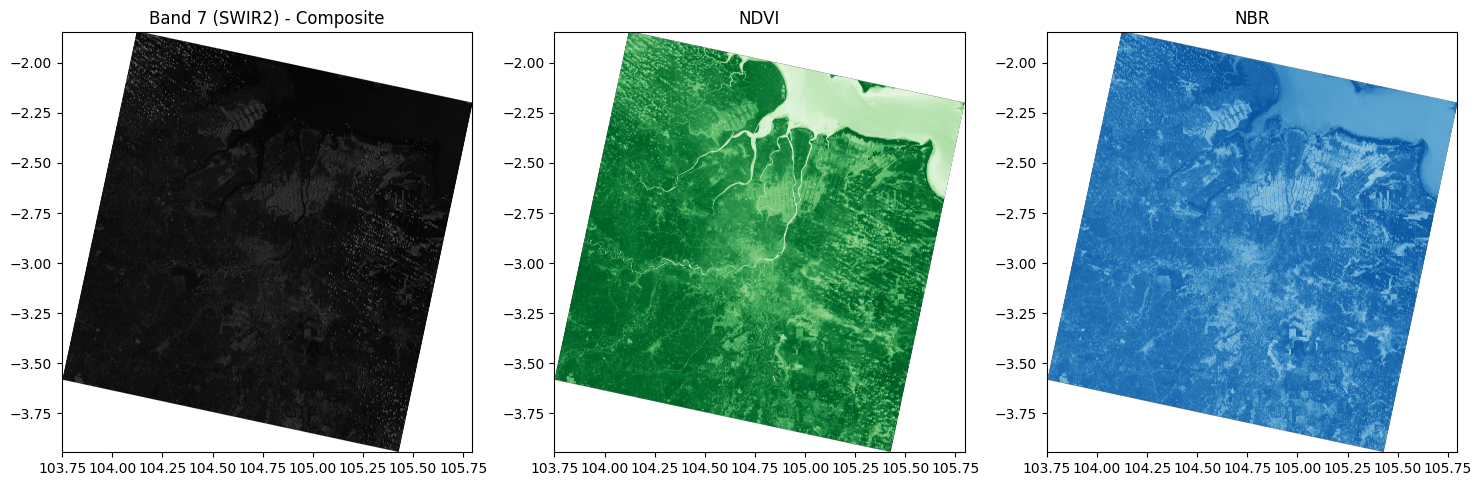

In [ ]:
import rasterio
from rasterio.plot import show
import numpy as np
import matplotlib.pyplot as plt

# ======================
# 1. Masukkan PATH FILE
# ======================
path_composite = '/content/drive/MyDrive/GEE_Exports/Composite_764_Susmel_2023.tif'  # Ganti path komposit 764
path_ndvi = '/content/drive/MyDrive/GEE_Exports/NDVI_Susmel_2023.tif'
path_nbr = '/content/drive/MyDrive/GEE_Exports/NBR_Susmel_2023.tif'

# ======================
# 2. Buka dan baca setiap raster
# ======================
with rasterio.open(path_composite) as composite_src:
    composite = composite_src.read()  # read() -> ambil semua band komposit 764
    meta = composite_src.meta.copy()  # Simpan metadata referensi

with rasterio.open(path_ndvi) as ndvi_src:
    ndvi = ndvi_src.read(1)

with rasterio.open(path_nbr) as nbr_src:
    nbr = nbr_src.read(1)

# ======================
# 3. Stack array komposit (3 bands) + NDVI + NBR -> jadi 5 bands
# ======================
stacked_array = np.vstack([composite, ndvi[np.newaxis, :, :], nbr[np.newaxis, :, :]])

# ======================
# 4. Update metadata supaya sesuai dengan jumlah band baru (5 bands)
# ======================
meta.update({
    'count': stacked_array.shape[0]  # 3 band komposit + 1 NDVI + 1 NBR = 5 bands
})

# ======================
# 5. Simpan ke file baru (GeoTIFF multiband)
# ======================
output_path = '/content/drive/MyDrive/GEE_Exports/stacked_composite_ndvi_nbr.tif'

with rasterio.open(output_path, 'w', **meta) as dst:
    dst.write(stacked_array)

print(f'Citra multiband berhasil disimpan di: {output_path}')

# Read Citra Multiband

### versi 1

CRS          : EPSG:4326
Ukuran Citra : 7593 x 7773
Jumlah Bands : 5


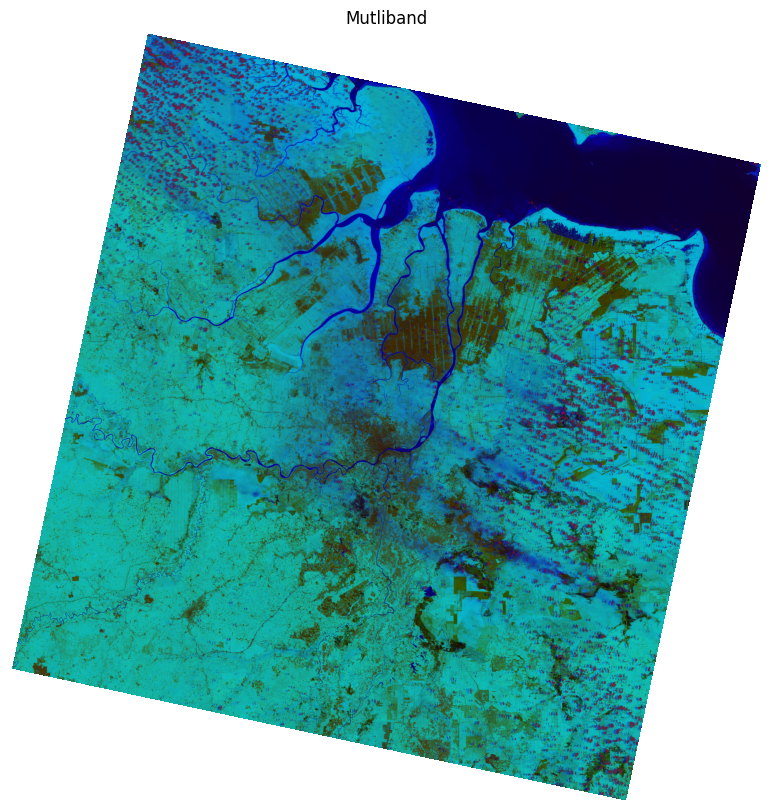

In [ ]:
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt

path_tif = '/content/drive/MyDrive/GEE_Exports/stacked_composite_ndvi_nbr.tif'

with rasterio.open(path_tif) as src:
    print(f'CRS          : {src.crs}')
    print(f'Ukuran Citra : {src.width} x {src.height}')
    print(f'Jumlah Bands : {src.count}')

    # Ambil 3 band (contoh Band 1, Band 4, Band 5)
    band1 = src.read(1)
    band4 = src.read(4)
    band5 = src.read(5)

    # Stack jadi RGB (order R, G, B)
    rgb = np.dstack((band1, band4, band5))

    # Plot RGB Image
    plt.figure(figsize=(10, 10))
    plt.title('Mutliband')
    plt.imshow(rgb)
    plt.axis('off')
    plt.show()


CRS          : EPSG:4326
Ukuran Citra : 7593 x 7773
Jumlah Bands : 5


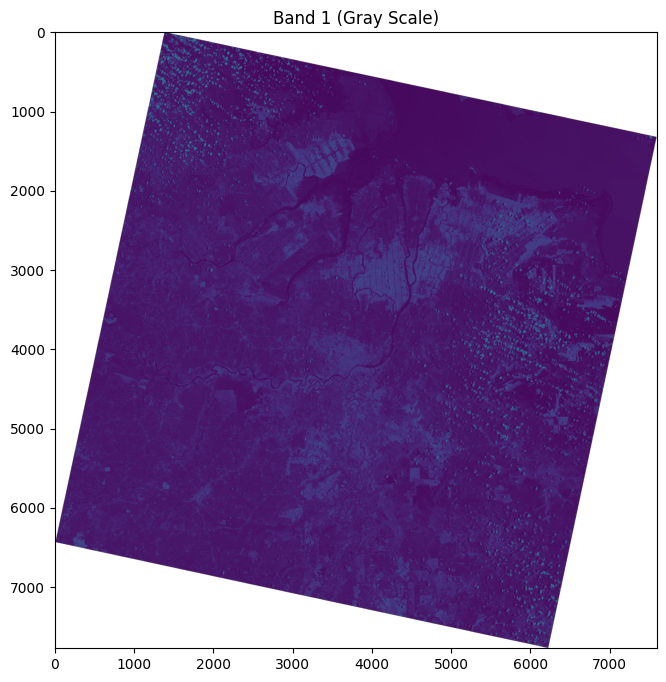

In [ ]:
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt

# ======================
# 1. Masukkan path citra TIF
# ======================
path_tif = '/content/drive/MyDrive/GEE_Exports/stacked_composite_ndvi_nbr.tif'

# ======================
# 2. Buka file TIF dengan rasterio
# ======================
with rasterio.open(path_tif) as src:
    print(f'CRS          : {src.crs}')
    print(f'Ukuran Citra : {src.width} x {src.height}')
    print(f'Jumlah Bands : {src.count}')

    # ======================
    # 3. Tampilkan satu band (contoh band ke-1)
    # ======================
    band1 = src.read(1)

    plt.figure(figsize=(8, 8))
    plt.title("Band 1 (Gray Scale)")
    show(band1, cmap='viridis')
    plt.show()


### Versi 2

In [ ]:
import rasterio

path = '/content/drive/MyDrive/GEE_Exports/stacked_composite_ndvi_nbr.tif'

with rasterio.open(path) as src:
    print("Jumlah band:", src.count)
    for i in range(1, src.count + 1):
        print(f"Band {i}: {src.descriptions}")  # Kalo ada deskripsi


Jumlah band: 5
Band 1: (None, None, None, None, None)
Band 2: (None, None, None, None, None)
Band 3: (None, None, None, None, None)
Band 4: (None, None, None, None, None)
Band 5: (None, None, None, None, None)


In [ ]:
import numpy as np

with rasterio.open(path) as src:
    band1 = src.read(1)
    band2 = src.read(2)
    band3 = src.read(3)
    band4 = src.read(4)
    band5 = src.read(5)


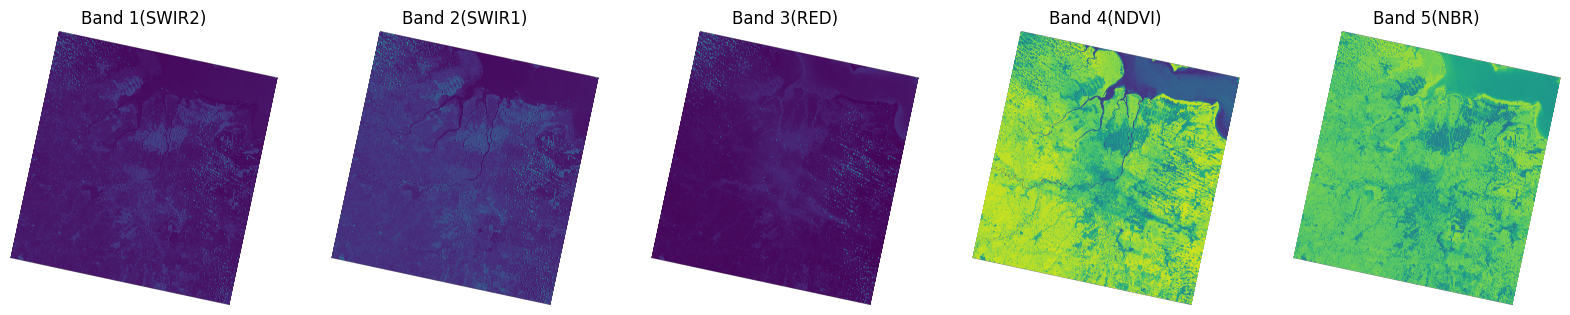

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 5, figsize=(20, 5))

bands = [band1, band2, band3, band4, band5]
titles = ['Band 1(SWIR2)', 'Band 2(SWIR1)', 'Band 3(RED)', 'Band 4(NDVI)', 'Band 5(NBR)']

for i in range(5):
    axs[i].imshow(bands[i], cmap='viridis')
    axs[i].set_title(titles[i])
    axs[i].axis('off')

plt.show()


#Citra Pre, Citra Post, CItra dNBR

In [ ]:
import ee
import folium
import geemap.foliumap as geemap


# Fungsi untuk menambahkan layer GEE ke Folium
def add_ee_layer(self, ee_image_object, vis_params, name):
    map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
    folium.raster_layers.TileLayer(
        tiles=map_id_dict['tile_fetcher'].url_format,
        attr='Google Earth Engine',
        name=name,
        overlay=True,
        control=True
    ).add_to(self)

# Tambahkan fungsi ke folium
folium.Map.add_ee_layer = add_ee_layer

# ====================================
# Region Sumatera Selatan (Sumsel)
# ====================================
sumsel_point = ee.Geometry.Point([104.7458, -3.3194])

# ====================================
# Ambil Citra Landsat 9 Sebelum Kebakaran
# ====================================
pre_fire = ee.ImageCollection('LANDSAT/LC09/C02/T1_TOA') \
    .filterBounds(sumsel_point) \
    .filterDate('2023-01-01', '2023-06-30') \
    .sort('CLOUD_COVER') \
    .first()

# Ambil Citra Landsat 9 Setelah Kebakaran
post_fire = ee.ImageCollection('LANDSAT/LC09/C02/T1_TOA') \
    .filterBounds(sumsel_point) \
    .filterDate('2023-07-01', '2023-12-01') \
    .sort('CLOUD_COVER') \
    .first()

# Validasi ketersediaan citra
if pre_fire is None or post_fire is None:
    raise Exception('Tidak ada citra yang ditemukan untuk periode sebelum/sesudah kebakaran.')

# ====================================
# Buat Komposit Warna 7-6-4 (SWIR2, SWIR1, RED)
# ====================================
composite_764_pre = pre_fire.select(['B7', 'B6', 'B4'])
composite_764_post = post_fire.select(['B7', 'B6', 'B4'])

composite_vis_params = {
    'min': 0.0,
    'max': 0.3,
    'gamma': 1.4
}

# ====================================
# Hitung NBR untuk Sebelum dan Sesudah
# ====================================
def calculate_nbr(image):
    nir = image.select('B5')
    swir2 = image.select('B7')
    return nir.subtract(swir2).divide(nir.add(swir2)).rename('NBR')

nbr_pre = calculate_nbr(pre_fire)
nbr_post = calculate_nbr(post_fire)

# ====================================
# Hitung dNBR
# ====================================
dnbr = nbr_pre.subtract(nbr_post).rename('dNBR')

dnbr_vis_params = {
    'min': -0.5,
    'max': 1,
    'palette': ['white', 'yellow', 'orange', 'red', 'brown', 'black']
}

# ====================================
# Buat Peta Interaktif
# ====================================
m = folium.Map(location=[-3.3194, 104.7458], zoom_start=8)

# Tambahkan layer citra sebelum dan sesudah kebakaran
m.add_ee_layer(composite_764_pre, composite_vis_params, 'Citra Sebelum Kebakaran (Sumsel 764)')
m.add_ee_layer(composite_764_post, composite_vis_params, 'Citra Setelah Kebakaran (Sumsel 764)')

# Tambahkan layer NBR sebelum dan sesudah
nbr_vis_params = {
    'min': -1,
    'max': 1,
    'palette': ['black', 'red', 'yellow', 'green']
}

m.add_ee_layer(nbr_pre, nbr_vis_params, 'NBR Sebelum Kebakaran (Sumsel)')
m.add_ee_layer(nbr_post, nbr_vis_params, 'NBR Setelah Kebakaran (Sumsel)')

# Tambahkan layer dNBR
m.add_ee_layer(dnbr, dnbr_vis_params, 'dNBR (Sumsel)')

# Layer control
m.add_child(folium.LayerControl())

# Tampilkan peta
m


In [ ]:
import ee
import folium
import geemap.foliumap as geemap


# Fungsi untuk menambahkan layer GEE ke Folium
def add_ee_layer(self, ee_image_object, vis_params, name):
    map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
    folium.raster_layers.TileLayer(
        tiles=map_id_dict['tile_fetcher'].url_format,
        attr='Google Earth Engine',
        name=name,
        overlay=True,
        control=True
    ).add_to(self)

folium.Map.add_ee_layer = add_ee_layer

# ====================================
# Region Sumatera Selatan (Sumsel) - Fokus Area Kecil
# ====================================
# Contoh area kecil (kotak sekitar 2km x 2km) di Sumatera Selatan
roi_sumsel = ee.Geometry.Rectangle([104.70, -3.33, 104.72, -3.31])

# ====================================
# Ambil Citra Landsat 9 Sebelum Kebakaran (ROI)
# ====================================
pre_fire = ee.ImageCollection('LANDSAT/LC09/C02/T1_TOA') \
    .filterBounds(roi_sumsel) \
    .filterDate('2023-01-01', '2023-06-30') \
    .sort('CLOUD_COVER') \
    .first() \
    .clip(roi_sumsel)  # Fokus area kecil!

# Ambil Citra Landsat 9 Setelah Kebakaran (ROI)
post_fire = ee.ImageCollection('LANDSAT/LC09/C02/T1_TOA') \
    .filterBounds(roi_sumsel) \
    .filterDate('2023-07-01', '2023-12-01') \
    .sort('CLOUD_COVER') \
    .first() \
    .clip(roi_sumsel)  # Fokus area kecil!

# Validasi ketersediaan citra
if pre_fire is None or post_fire is None:
    raise Exception('Tidak ada citra yang ditemukan untuk periode sebelum/sesudah kebakaran.')

# ====================================
# Buat Komposit Warna 7-6-4 (SWIR2, SWIR1, RED)
# ====================================
composite_764_pre = pre_fire.select(['B7', 'B6', 'B4'])
composite_764_post = post_fire.select(['B7', 'B6', 'B4'])

composite_vis_params = {
    'min': 0.0,
    'max': 0.3,
    'gamma': 1.4
}

# ====================================
# Hitung NBR untuk Sebelum dan Sesudah
# ====================================
def calculate_nbr(image):
    nir = image.select('B5')
    swir2 = image.select('B7')
    return nir.subtract(swir2).divide(nir.add(swir2)).rename('NBR')

nbr_pre = calculate_nbr(pre_fire)
nbr_post = calculate_nbr(post_fire)

# ====================================
# Hitung dNBR
# ====================================
dnbr = nbr_pre.subtract(nbr_post).rename('dNBR')

dnbr_vis_params = {
    'min': -0.5,
    'max': 1,
    'palette': ['white', 'yellow', 'orange', 'red', 'brown', 'black']
}

# ====================================
# Buat Peta Interaktif (Zoom ke ROI)
# ====================================
center_point = roi_sumsel.centroid().coordinates().getInfo()
m = folium.Map(location=[center_point[1], center_point[0]], zoom_start=14)

# Tambahkan layer citra sebelum dan sesudah kebakaran
m.add_ee_layer(composite_764_pre, composite_vis_params, 'Citra Sebelum Kebakaran (Sumsel ROI)')
m.add_ee_layer(composite_764_post, composite_vis_params, 'Citra Setelah Kebakaran (Sumsel ROI)')

# Tambahkan layer NBR sebelum dan sesudah
nbr_vis_params = {
    'min': -1,
    'max': 1,
    'palette': ['black', 'red', 'yellow', 'green']
}

m.add_ee_layer(nbr_pre, nbr_vis_params, 'NBR Sebelum Kebakaran (Sumsel ROI)')
m.add_ee_layer(nbr_post, nbr_vis_params, 'NBR Setelah Kebakaran (Sumsel ROI)')

# Tambahkan layer dNBR
m.add_ee_layer(dnbr, dnbr_vis_params, 'dNBR (Sumsel ROI)')

# Layer control
m.add_child(folium.LayerControl())

# Tampilkan peta
m
